*kursiver Text*# Digital Twin Survey 

**NOTE:**
You will be prompted to upload a text file from your Google Drive.

If you would like to use the file that was used in this example, copy it from this link to your Google Drive:

https://github.com/gal-a/blog/blob/master/docs/notebooks/nlp/data/quotes.txt

In [ ]:
# Setup
!pip install -q wordcloud
import wordcloud

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('genesis')
nltk.download('averaged_perceptron_tagger') 
from nltk.collocations import *
import pandas as pd
import matplotlib.pyplot as plt
import io
import unicodedata
import numpy as np
import re
import string
# Constants
# POS (Parts Of Speech) for: nouns, adjectives, verbs and adverbs
DI_POS_TYPES = {'NN':'n', 'JJ':'a', 'VB':'v', 'RB':'r'} 
POS_TYPES = list(DI_POS_TYPES.keys())

# Constraints on tokens
MIN_STR_LEN = 3
RE_VALID = '[a-zA-Z]'

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package genesis to /root/nltk_data...
[nltk_data]   Unzipping corpora/genesis.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Load the corpus file from Google Drive

In [ ]:
# Upload from google drive
from google.colab import files
uploaded = files.upload()
print("len(uploaded.keys():", len(uploaded.keys()))

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

# Get coding list
df_references = pd.read_csv(io.StringIO(uploaded['coding.txt'].decode('utf-8')), sep=',', keep_default_na=False)
  
# Display
print("references:")
print(df_references.head().to_string())


Saving coding.txt to coding (1).txt
len(uploaded.keys(): 1
User uploaded file "coding.txt" with length 119457 bytes
references:
             Key Relevance                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         Contribution                                                                                                                                                                                                                    Definition                                                                                                                           



```
# Als Code formatiert
```

## Identify relevant words defining the Digital Twin


               lem pos  counts
0          digital  NN     120
1             twin  NN      90
2         physical  JJ      77
3          virtual  JJ      43
4           system  NN      41
5             data  NN      33
6   representation  NN      27
7            model  NN      27
8           object  NN      21
9           device  NN      19
10         product  NN      17
11           asset  NN      16
12         replica  NN      16
13      simulation  NN      16
14             use  VB      15
15     counterpart  NN      15
16         process  NN      14
17          entity  NN      13
18          mirror  NN      12
19       represent  VB      11
20           world  NN      11
21        behavior  NN      10
22          define  VB      10
23       realworld  NN      10
24            real  JJ       9
25        realtime  NN       8
26          sensor  NN       7
27       lifecycle  NN       7
28        security  NN       7
29            base  VB       7
30        software  NN       7
31      

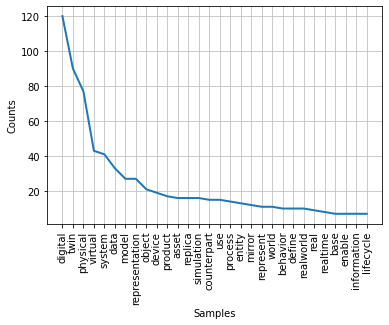

In [ ]:
li_relevance = df_references['Definition'].tolist()


# Get stopwords, stemmer and lemmatizer
stopwords = nltk.corpus.stopwords.words('english')
stemmer = nltk.stem.PorterStemmer()
lemmatizer = nltk.stem.WordNetLemmatizer()

# Remove accents function
def remove_accents(data):
    return ''.join(x for x in unicodedata.normalize('NFKD', data) if x in string.ascii_letters or x == " ")

# Process all quotes
li_tokens = []
li_token_lists = []
li_lem_strings = []

for i,text in enumerate(li_relevance):
    # Tokenize by sentence, then by lowercase word
    if not text:
      text = ''
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]

    # Process all tokens per quote
    li_tokens_quote = []
    li_tokens_quote_lem = []
    for token in tokens:
        # Remove accents
        t = remove_accents(token)

        # Remove punctuation
        t = str(t).translate(string.punctuation)
        li_tokens_quote.append(t)
        
        # Add token that represents "no lemmatization match"
        li_tokens_quote_lem.append("-") # this token will be removed if a lemmatization match is found below

        # Process each token
        if t not in stopwords:
            if re.search(RE_VALID, t):
                if len(t) >= MIN_STR_LEN:
                    # Note that the POS (Part Of Speech) is necessary as input to the lemmatizer 
                    # (otherwise it assumes the word is a noun)
                    pos = nltk.pos_tag([t])[0][1][:2]
                    pos2 = 'n'  # set default to noun
                    if pos in DI_POS_TYPES:
                      pos2 = DI_POS_TYPES[pos]
                    
                    stem = stemmer.stem(t)
                    lem = lemmatizer.lemmatize(t, pos=pos2)  # lemmatize with the correct POS
                    
                    if pos in POS_TYPES:
                        li_tokens.append((t, stem, lem, pos))

                        # Remove the "-" token and append the lemmatization match
                        li_tokens_quote_lem = li_tokens_quote_lem[:-1] 
                        li_tokens_quote_lem.append(lem)

    # Build list of token lists from lemmatized tokens
    li_token_lists.append(li_tokens_quote)
    
    # Build list of strings from lemmatized tokens
    str_li_tokens_quote_lem = ' '.join(li_tokens_quote_lem)
    li_lem_strings.append(str_li_tokens_quote_lem)
    
# Build resulting dataframes from lists
df_token_lists = pd.DataFrame(li_token_lists)


# Replace None with empty string
for c in df_token_lists:
    if str(df_token_lists[c].dtype) in ('object', 'string_', 'unicode_'):
        df_token_lists[c].fillna(value='', inplace=True)

df_lem_strings = pd.DataFrame(li_lem_strings, columns=['lem quote'])


# Add counts
df_all_words = pd.DataFrame(li_tokens, columns=['token', 'stem', 'lem', 'pos'])
df_all_words['counts'] = df_all_words.groupby(['lem'])['lem'].transform('count')
df_all_words = df_all_words.sort_values(by=['counts', 'lem'], ascending=[False, True]).reset_index()

df_words = df_all_words.groupby('lem').first().sort_values(by='counts', ascending=False).reset_index()

df_words = df_words[['lem', 'pos', 'counts']].head(60)
print(df_words)

for v in POS_TYPES:
    df_pos = df_words[df_words['pos'] == v]
 
li_lem_words = df_all_words['lem'].tolist()
di_freq2 = nltk.FreqDist(li_lem_words)
li_freq_sorted2 = sorted(di_freq2.items(), key=lambda x: x[1], reverse=True)  # sorted list
    
di_freq2.plot(30, cumulative=False)

In [ ]:
# Get stopwords, stemmer and lemmatizer
stopwords = nltk.corpus.stopwords.words('english')
stemmer = nltk.stem.PorterStemmer()
lemmatizer = nltk.stem.WordNetLemmatizer()

# Remove accents function
def remove_accents(data):
    return ''.join(x for x in unicodedata.normalize('NFKD', data) if x in string.ascii_letters or x == " ")

# Process all quotes
li_tokens = []
li_token_lists = []
li_lem_strings = []

for i,word in enumerate(li_lem_words):
    
    word_list = []
    for index, row in df_references.iterrows():
      key = row["Key"]
      definition = row["Definition"]
      tokens = [word.lower() for sent in nltk.sent_tokenize(definition) for word in nltk.word_tokenize(sent)]

      # Process all tokens per quote
      li_tokens_quote = []
      li_tokens_quote_lem = []
      for token in tokens:
        # Remove accents
          t = remove_accents(token)

        # Remove punctuation
          t = str(t).translate(string.punctuation)
          li_tokens_quote.append(t)
        
          # Add token that represents "no lemmatization match"
          li_tokens_quote_lem.append("-") # this token will be removed if a lemmatization match is found below

          # Process each token 
          if t not in stopwords:
              if re.search(RE_VALID, t):
                  if len(t) >= MIN_STR_LEN:
                      # Note that the POS (Part Of Speech) is necessary as input to the lemmatizer 
                      # (otherwise it assumes the word is a noun)
                      pos = nltk.pos_tag([t])[0][1][:2]
                      pos2 = 'n'  # set default to noun
                      if pos in DI_POS_TYPES:
                        pos2 = DI_POS_TYPES[pos]
                    
                      stem = stemmer.stem(t)
                      lem = lemmatizer.lemmatize(t, pos=pos2)  # lemmatize with the correct POS
                       
                      if word == lem:
                        word_list.append(lem)

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
fly
twin
digital
twin
technology
model
asset
geometrical
data
kinematic
functionality
logical
behaviour
use
digital
tool
useful
information
relates
physical
system
virtualized
model
digital
twin
online
digital
model
physical
system
digital
replica
living
nonliving
physical
entity
digital
twin
consists
two
part
digital
twin
model
digital
twin
capability
digital
twin
model
refers
digital
representation
cps
could
virtual
prototype
cps
reflect
partial
entire
physical
process
mirror
internal
behaviour
physical
system
perspective
autonomous
vehicle
digital
twinrefers
effort
place
design
implementation
process
need
enhance
safety
security
privacy
driverless
car
dts
prove
usefully
optimise
system
base
collect
data
system
responds
change
set
help
stakeholder
realise
unexploited
potential
improve
operational
security
simulation
also
fastforwarded
foresee
ect
update
repair
preventive
maintenance
even
future
threat
high
level
digit

KeyboardInterrupt: ignored


```
# Als Code formatiert
```

## Identify relevant words 


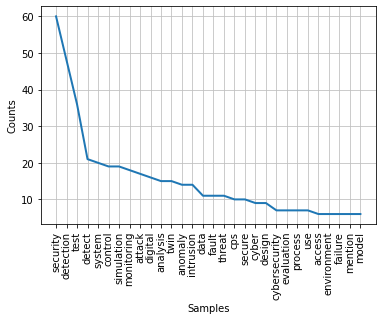

In [ ]:
data = []
 
# Creating plot
fig = plt.figure(figsize =(10, 7))
plt.pie(data, labels = cars)
 
# show plot
plt.show()

In [ ]:

bigram_measures = nltk.collocations.BigramAssocMeasures()
trigram_measures = nltk.collocations.TrigramAssocMeasures()

definition_list = df_references['Definition'].tolist()
definition_string = " ".join(str(x) for x in definition_list)

# change this to read in your data
finder = BigramCollocationFinder.from_words(definition_string)

# only bigrams that appear 3+ times
finder.apply_freq_filter(10)

# return the 10 n-grams with the highest PMI
finder.nbest(bigram_measures.pmi, 10)

[('N', '/'),
 ('/', 'A'),
 ('b', 'j'),
 (']', '.'),
 ('D', 'T'),
 ('T', 'w'),
 ('-', 'w'),
 ('l', '-'),
 ('i', 'z'),
 ('j', 'e')]